# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<font size='5'>**Цели проекта:**</font>

**Определить риски и вычислить потенциальную прибыль от месторождений выбранного региона.**

**Выявить регион с риском убытка менее 2.5%**

<font size='5'>**Ход проекта:**</font>
* **Знакомство с данными и их обработка**
* **Обучение и проверка модели**
* **Подготовка к рассчёты прибыли**
* **Расчёт прибыли и рисков**
* **Выбор региона**

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt   
import seaborn as sns 

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
print(data0.head())
print(data1.head())
data2.head()

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


id — уникальный идентификатор скважины, далее снесём этот столбец.

f0, f1, f2 — три признака точек.

product — объём запасов в скважине (тыс. баррелей).

In [4]:
print(data0.shape)
print(data1.shape)
print(data2.shape)

(100000, 5)
(100000, 5)
(100000, 5)


**100тыс строк и 5 столбцов**

In [5]:
print(data0.duplicated().sum())
print(data1.duplicated().sum())
print(data2.duplicated().sum())

0
0
0


In [6]:
print(len(data0['id'].unique()))
print(len(data1['id'].unique()))
print(len(data2['id'].unique()))

99990
99996
99996


**Уникальных значений меньше чем длина сетов**

In [7]:
print(data0.duplicated(subset='id').sum())
print(data1.duplicated(subset='id').sum())
print(data2.duplicated(subset='id').sum())

10
4
4


**В каждый сет положили подводный камень.**

In [8]:
print(data0.loc[data0.duplicated(subset='id') == True])
print(data1.loc[data1.duplicated(subset='id') == True])
print(data2.loc[data2.duplicated(subset='id') == True])

          id        f0        f1         f2     product
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
90815  fiKDv  0.049883  0.841313   6.394613  137.346586
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
          id         f0        f1        f2     product
41906  LHZR0  -8.989672 -4.286607  2.009139   57.085625
82178  bfPNe  -6.202799 -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972 -9.376355  4.994297  134.766305
84461  5ltQ6  18.213839  2.191999  3.993869  107.813044
          id        f0        f1        f2     product
43233  xCHr8 -0.847066  2.101796  5.597130  184.3

**Ради интереса глянул что-за пропуски.**

In [9]:
data0 = data0.drop_duplicates(subset='id')
data1 = data1.drop_duplicates(subset='id')
data2 = data2.drop_duplicates(subset='id')

**Дроп дубликатов.**

In [10]:
print(data0.shape)
print(data1.shape)
print(data2.shape)

(99990, 5)
(99996, 5)
(99996, 5)


**Сверка размера сета после удаления, всё в порядке.**

In [11]:
print(data0.isna().sum())
print(data1.isna().sum())
print(data2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


**Пропущенных значений нет**

In [12]:
print(data0.info())
print(data1.info())
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  

**Соответствующие типы данных.**

In [13]:
data0 = data0.drop('id', axis=1)
data1 = data1.drop('id', axis=1)
data2 = data2.drop('id', axis=1)

**Дроп столбца ID-шников, могут оказать негативное влияние на обучение модели.**

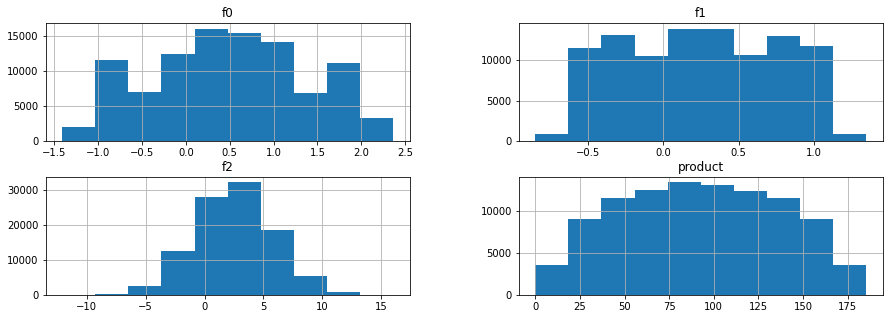

In [14]:
data0.hist(figsize=(15,5));

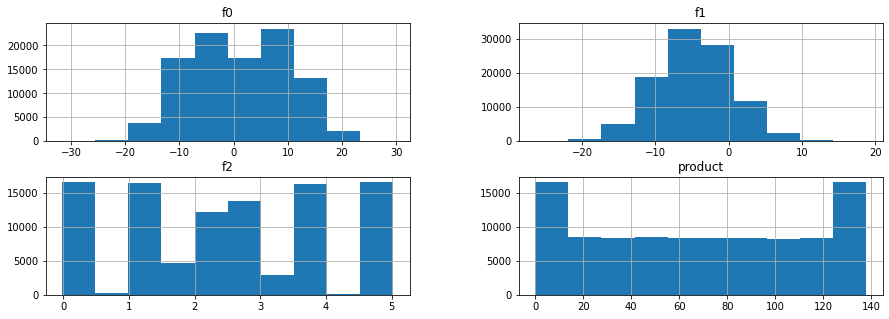

In [15]:
data1.hist(figsize=(15,5));

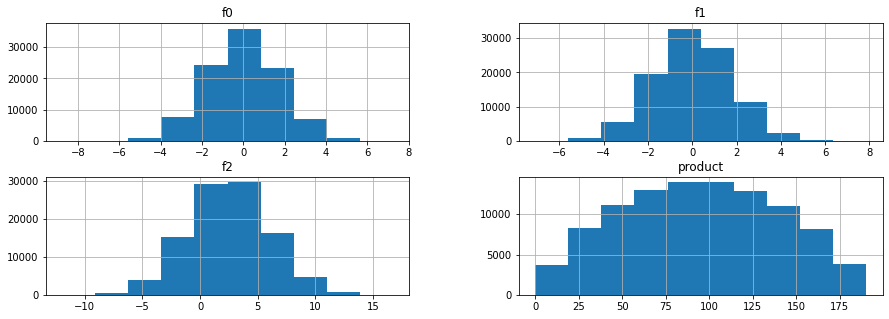

In [16]:
data2.hist(figsize=(15,5));

**На гистограммах видно отсутствие выбросов.**

### Промежуточный вывод:

* **Имеем 3 датасета на 100тыс. строк и 5 столбцов каждый.**
* **Удалены единичные дубликаты в сетах**
* **Предобработки данных почти не понадобилось, удалили один столбец с ID скважин.**

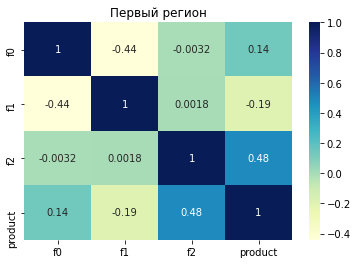

In [17]:
sns.heatmap(data0.corr(), cmap="YlGnBu", annot=True)
plt.title('Первый регион')
plt.show()

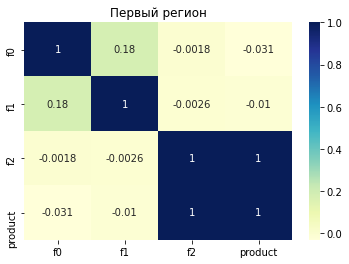

In [18]:
sns.heatmap(data1.corr(), cmap="YlGnBu", annot=True)
plt.title('Первый регион')
plt.show()

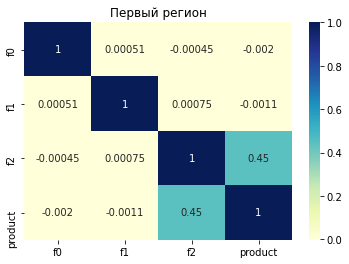

In [19]:
sns.heatmap(data2.corr(), cmap="YlGnBu", annot=True)
plt.title('Первый регион')
plt.show()

## Обучение и проверка модели

In [20]:
data = [data0, data1, data2] # Делаю список что-бы обращаться к данным в цикле.

predictions0 = [] # Сохраняю предсказания модели и правильные ответы.
target_valid0 = []

predictions1 = []
target_valid1 = []

predictions2 = []
target_valid2 = []

count = -1


for i in data:    
    features = i.drop('product', axis=1)
    target = i['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features, target, # Разделяю выборку.
                                                                              test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid) # обучаем модель.
    count += 1
    if count == 0:
        target_valid0 = target_valid
        predictions0 = predictions
        print('Средние запасы первого региона:', predictions.mean().round(4), 'Тыс.Баррелей.')
        print('RMSE модели:', (mse(predictions, target_valid)**0.5).round(4))
        print()       # После того как это написал подумал что удобнее было бы черезе функцию, переделывать не стал.
    if count == 1:
        target_valid1 = target_valid
        predictions1 = predictions
        print('Средние запасы второго региона:', predictions.mean().round(4), 'Тыс.Баррелей.')
        print('RMSE модели:', (mse(predictions, target_valid)**0.5).round(4))
        print()
    if count == 2:
        target_valid2 = target_valid
        predictions2 = predictions
        print('Средние запасы третьего региона:', predictions.mean().round(4), 'Тыс.Баррелей.')
        print('RMSE модели:', (mse(predictions, target_valid)**0.5).round(4))
        print()
    

Средние запасы первого региона: 92.7892 Тыс.Баррелей.
RMSE модели: 37.8535

Средние запасы второго региона: 69.1783 Тыс.Баррелей.
RMSE модели: 0.8921

Средние запасы третьего региона: 94.8657 Тыс.Баррелей.
RMSE модели: 40.0759



### Промежуточный вывод:

* **У первой и третьей модели очень высокая степень ошибки(40тыс.бар.) при среднем в регионе ~95.**

* **у второй модели слишком маленькая степень ошибки, вероятно модель переобучилась.**

## Подготовка к расчёту прибыли

In [21]:
points = 500
top_points = 200    # Записываем данные в переменные.
budget = 10000000000
barrel_income = 450*1000
prob = 0.025

In [22]:
point_budget = budget/200 # Средняя цена одной скважины.
payback = point_budget/barrel_income # Нужный объём скважины для того что-бы она окупилась.
print('Средний объём скважин должен быть не менее:', int(payback), 'Тыс.Баррелей.')

print('Средний объем первого региона', data0['product'].mean().round(3), 'Тыс.Баррелей.')
print('Средний объем второго региона', data1['product'].mean().round(3), 'Тыс.Баррелей.')
print('Средний объем третьего региона', data2['product'].mean().round(3), 'Тыс.Баррелей.')

Средний объём скважин должен быть не менее: 111 Тыс.Баррелей.
Средний объем первого региона 92.5 Тыс.Баррелей.
Средний объем второго региона 68.824 Тыс.Баррелей.
Средний объем третьего региона 94.998 Тыс.Баррелей.


### Промежуточный вывод:

**Средний объём скважин в отдельно взятом регионе значительно ниже порога окупаемости, у первого и третьего региона средний объём 92.5 и 95 Т.Баррелей при минимальном объёме для окупаемости в 111 Т.Баррелей.**

**Но если мы будем многократно случайным образом выбирать отдельно взятые 200 скважин из всего объёма, мы сможем рассчитать возможную прибыль и риски, в общем методом бутстрапирования мы вычислим значения и на их основе сделаем выводы о том даст какой-либо регион прибыль и мы сможем вывести решение о дальнейшей разработки.**

## Расчёт прибыли и рисков 

In [23]:
def income(target_valid, predictions_valid, n): # Функция для расчёта прибыли
    
    target = target_valid.reset_index(drop = True)
    predictions = pd.Series(predictions_valid, index = target.index) 
    best_points = target[predictions.sort_values(ascending = False).index][:n]
    
    return (best_points.sum() * barrel_income - budget) / 1000000

In [24]:
def region(target, pred, n):       # Создаём функцию для того что-бы далее кормить ей каждый регион по отдельности.
    state = np.random.RandomState(12345)
    incomes = []

    for i in range(1000):       # Копирую код из учебного материала и подставляю наши значения.
        target_subsample = target.reset_index(drop= True).sample(n, random_state=state, replace=True)
        probs_subsample = pred[target_subsample.index]
        incomes.append(income(target_subsample, probs_subsample, 200))
    
    incomes = pd.Series(incomes)    
    loss = incomes[incomes<0].count()/1000

    lower = incomes.quantile(0.025)
    upper = incomes.quantile(.975)

    print('Средняя прибыль от 200 скважин:', (incomes.mean().round(2)), 'млн.руб.')
    print('95% доверительный интервал от 200 скважин:', lower.round(3),
          '-', upper.round(3))
    print('Вероятность убытка:', loss*100, '%')

In [25]:
region(target_valid0, predictions0, 500)

Средняя прибыль от 200 скважин: 380.61 млн.руб.
95% доверительный интервал от 200 скважин: -142.943 - 890.977
Вероятность убытка: 7.7 %


In [26]:
region(target_valid1, predictions1, 500)

Средняя прибыль от 200 скважин: 478.48 млн.руб.
95% доверительный интервал от 200 скважин: 89.525 - 866.605
Вероятность убытка: 1.2 %


In [27]:
region(target_valid2, predictions2, 500)

Средняя прибыль от 200 скважин: 330.55 млн.руб.
95% доверительный интервал от 200 скважин: -190.366 - 840.467
Вероятность убытка: 11.3 %


### Промежуточный вывод:

**Все три региона потенциально выгодны, но лишь второй регион подходит под нашу задачу, вероятность убытка всего 1.5%**

## Вывод:

* **Проведена оценка и предобработка данных.**
* **Проведена проверка и обучение модели**
* **При подготовке к расчёту прибыли относительно объёма скважин выявлено, что средний объём скважин в отдельно взятом регионе значительно ниже порога окупаемости, у первого и третьего региона средний объём 92.5 и 95 Т.Баррелей при минимальном объёме для окупаемости в 111 Т.Баррелей.**
* **Рассчёт прибыли и рисков с помощью Bootstrap на основе данных модели LinearRegression показали что от 200 взятых скважин среди исследуемых 500 скважин - средняя прибыль составит 356млн.руб., 95% доверительный интервал состовляет от 33 до 852млн.руб., а также вероятность убытка всего в 1.5%**